# Visualizing cmIF data with [napari](https://napari.org/)

#### Erik Burlingame

In [78]:
import os
from glob import glob
from natsort import natsorted
import tqdm
import itertools

import numpy as np
from numpy import arange
import pandas as pd
from PIL import Image

from skimage.measure import label, regionprops_table
from skimage.color import label2rgb
from skimage import img_as_ubyte
from skimage.segmentation import find_boundaries

from skimage.io import imread
from skimage.filters import threshold_otsu
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

from dask.cache import Cache
from IPython.display import Image, Video
import zarr
import dask.array as da
from skimage.transform import pyramid_gaussian

import napari

%gui qt5

* `napari` is a fast, interactive, multi-dimensional image viewer for Python. 
* It’s designed for browsing, annotating, and analyzing large multi-dimensional images. 
* It’s built on top of `Qt` (for the GUI), `vispy` (for performant GPU-based rendering), and the scientific Python stack (e.g. `numpy`, `scipy`). 
* It includes critical viewer features out-of-the-box, such as support for large multi-dimensional data, and layering and annotation. 
* By integrating closely with the Python ecosystem, `napari` can be easily coupled to leading machine learning and image analysis tools (e.g. `scikit-image`, `scikit-learn`, `TensorFlow`, `PyTorch`), enabling more user-friendly automated analysis.

I started by making a simple `Viewer` for TMA cmIF data. The `Viewer` ingests:
* the full image set for a given TMA core
* a table which describes the centroids of each cell and whether each cell is +/- for each cmIF marker
* cell and nuclear segmentations masks

In [52]:
class Viewer():
    """
    A (hacky) cmIF data viewer built on napari.
    """
    def __init__(self, root):
        
        print(f'Intializing viewer from dataset at {root}...')
        
        self.root   = root
        self.viewer = napari.Viewer()
        
        d = {}
        
        for fn in glob(f'{self.root}/Registered*.tif'):
            
            # parse filenames to get stain names
            tmp = os.path.basename(fn).split('_')
            stains = ['DAPI'] + tmp[1].split('.')
            channel = int(tmp[3][-1])-1
            
            if channel == 0:
                stain = 'DAPI'
            else:
                stain = stains[channel]
            
            d[stain] = fn

        for stain in tqdm.notebook.tqdm(sorted(d.keys(),reverse=True),desc='Loading image channels'):

            self.viewer.add_image(imread(d[stain]),
                                  name=stain,
                                  blending='additive',
                                  visible=False,
                                  opacity=0.5)
        
        # load threshold df and filter
        # TODO: add flexibility for df loading
        print('Loading threshold dataframe...')
        self.thresh = pd.read_csv(glob(f'{self.root}/*ManualPositive.csv')[0])
        self.thresh = self.thresh[(self.thresh.scene=='scene001') & (self.thresh.slide=='BR1506-A019')]
        self.thresh['centroid'] = list(zip(self.thresh['DAPI_Y'].round().astype('int'),
                                           self.thresh['DAPI_X'].round().astype('int')))
        
        cell_label_fn = glob(f'{self.root}/*Cell Segmentation Basins.tif')[0]
        nuc_label_fn  = glob(f'{self.root}/*Nuclei Segmentation Basins.tif')[0]
        
        print(f'Loading cell labels from {cell_label_fn}...')
        print(f'Loading nucleus labels from {nuc_label_fn}...')
        
        self.cell_labels = imread(cell_label_fn)
        self.nuc_labels  = imread(nuc_label_fn)
        
        self.cell_bounds = find_boundaries(self.cell_labels,mode='outer')
        self.nuc_bounds  = find_boundaries(self.nuc_labels,mode='outer')
        
        print('Viewer intialized...')

    def add_query_bounds(self, query, name):
        """
        Draws boundaries around your cells of interest
        """
        centroids     = self.thresh.loc[(self.thresh[list(query)] == pd.Series(query)).all(axis=1)]['centroid'].to_list()
        query_labels  = [self.cell_labels[c] for c in centroids]
        masked_labels = self.cell_labels * np.isin(self.cell_labels, query_labels)
        masked_bounds = find_boundaries(masked_labels)
        bounds_img    = img_as_ubyte(masked_bounds)
        
        self.viewer.add_image(bounds_img,
                              name=name,
                              metadata=query,
                              blending='additive')
        
        print(f'Boundaries for {name} cells added...')
    
    def cluster_cell_morphology(self, props, n_clusters):
        """
        Cluster cells based on simple morphology
        """
                
        # fit clusters based on morphology
        df = pd.DataFrame(regionprops_table(self.cell_labels, properties=props))
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df)
        df['cluster'] = kmeans.labels_+1
        
        # replace unique labels with cluster labels
        replace = {idx+1:cluster for idx,cluster in df['cluster'].iteritems()}
        mp = np.arange(0,self.cell_labels.max()+1)
        mp[list(replace.keys())] = list((replace.values()))
        data = mp[self.cell_labels]
        
        self.viewer.add_labels(data * ~self.cell_bounds, 
                               name='clusters',
                               blending='additive',
                               opacity=0.5)
        
        print('Cell morphology cluster labels added...')
    
    def threshold(self, img, t):
        arr = da.from_array(img, chunks=img.shape)
        return arr > t

    def explore_thresh(self, stain='DAPI', percentiles=(1,99.9), step=50):
        """
        Provides visual guidance for manual threshold selection
        """
        img = self.viewer.layers[stain].data
        
#         TODO: update threshs given user-specified contrast limits
#         from skimage.exposure import rescale_intensity as ri
#         img = ri(img,tuple(self.viewer.layers[stain].contrast_limits))

        p_low, p_high = np.percentile(img, percentiles)
        all_thresh = da.stack([self.threshold(img, t) for t in np.arange(p_low, p_high, step)])
        
        self.viewer.add_image(all_thresh,
                              name=f'{stain}_thresh', 
                              colormap='magenta', 
                              blending='additive')
        
        print(f'Added threshold explorer for {stain}...')
    

## Read-in all channels for a single TMA core

In [128]:
root = '/Users/burlinge/napari_demo'
viewer = Viewer('/Users/burlinge/napari_demo')

Intializing viewer from dataset at /Users/burlinge/napari_demo...



Loading threshold dataframe...
Loading cell labels from /Users/burlinge/napari_demo/Scene 001 - Cell Segmentation Basins.tif...
Loading nucleus labels from /Users/burlinge/napari_demo/Scene 001 - Nuclei Segmentation Basins.tif...
Viewer intialized...


## Label cells based on query

In [132]:
# query = {'CK19_Ring': True, 
#          'Ki67_Nuclei': True}
query = {'CK19_Ring':True,
        'Ecad_Ring':True}
viewer.add_query_bounds(query, 'CK19+/Ecad+')

Boundaries for CK19+/Ecad+ cells added...


## Cluster cells based on simple morphology

In [130]:
props = ['area',
         'convex_area',
         'eccentricity',
         'major_axis_length',
         'minor_axis_length',
         'perimeter',
         'solidity']

n_clusters = 5

viewer.cluster_cell_morphology(props, n_clusters)

Cell morphology cluster labels added...


## Explore stain intensity thresholds

In [131]:
viewer.explore_thresh('Her2')

Added threshold explorer for Her2...


### SMMART sample

In [43]:
# Convert pyramid to zarr
cache = Cache(3e9)  # Leverage three gigabytes of memory
cache.register()

root = '/Users/burlinge/napari_demo/smt101'

base = imread(glob(f'{root}/Registered*Scene-001*.tif')[2])

pyramid = list(pyramid_gaussian(base, downscale=2, max_layer=3, multichannel=False))

file_name = 'pyramid.zarr'

zarr_root = zarr.open_group(file_name, mode='a')
for i in range(0, len(pyramid)):
    shape = pyramid[i].shape
    z = zarr_root.create_dataset(str(i), shape=shape, chunks=(300,300), dtype='float')
    z[:] = pyramid[i]
    
pyramid = [da.from_zarr(file_name + '/' + str(i)) for i in range(len(pyramid))]

In [120]:
napari.view_image(pyramid)

RuntimeError: EventEmitter loop detected!

* Dask provides advanced parallelism for analytics, enabling performance at scale.
* Dask arrays coordinate many Numpy arrays, arranged into chunks within a grid.

In [48]:
pyramid[0]

dask.array<from-zarr, shape=(8059, 9454), dtype=float64, chunksize=(300, 300), chunktype=numpy.ndarray>

In [23]:
pyramid[1]

dask.array<from-zarr, shape=(4030, 4727), dtype=float64, chunksize=(300, 300), chunktype=numpy.ndarray>

In [24]:
pyramid[2]

dask.array<from-zarr, shape=(2015, 2364), dtype=float64, chunksize=(300, 300), chunktype=numpy.ndarray>

In [25]:
pyramid[3]

dask.array<from-zarr, shape=(1008, 1182), dtype=float64, chunksize=(300, 300), chunktype=numpy.ndarray>

* In spite of dask-boosted i/o performance, all channel layers had to be read, even when invisible, leading to major lag.
* So I complained...

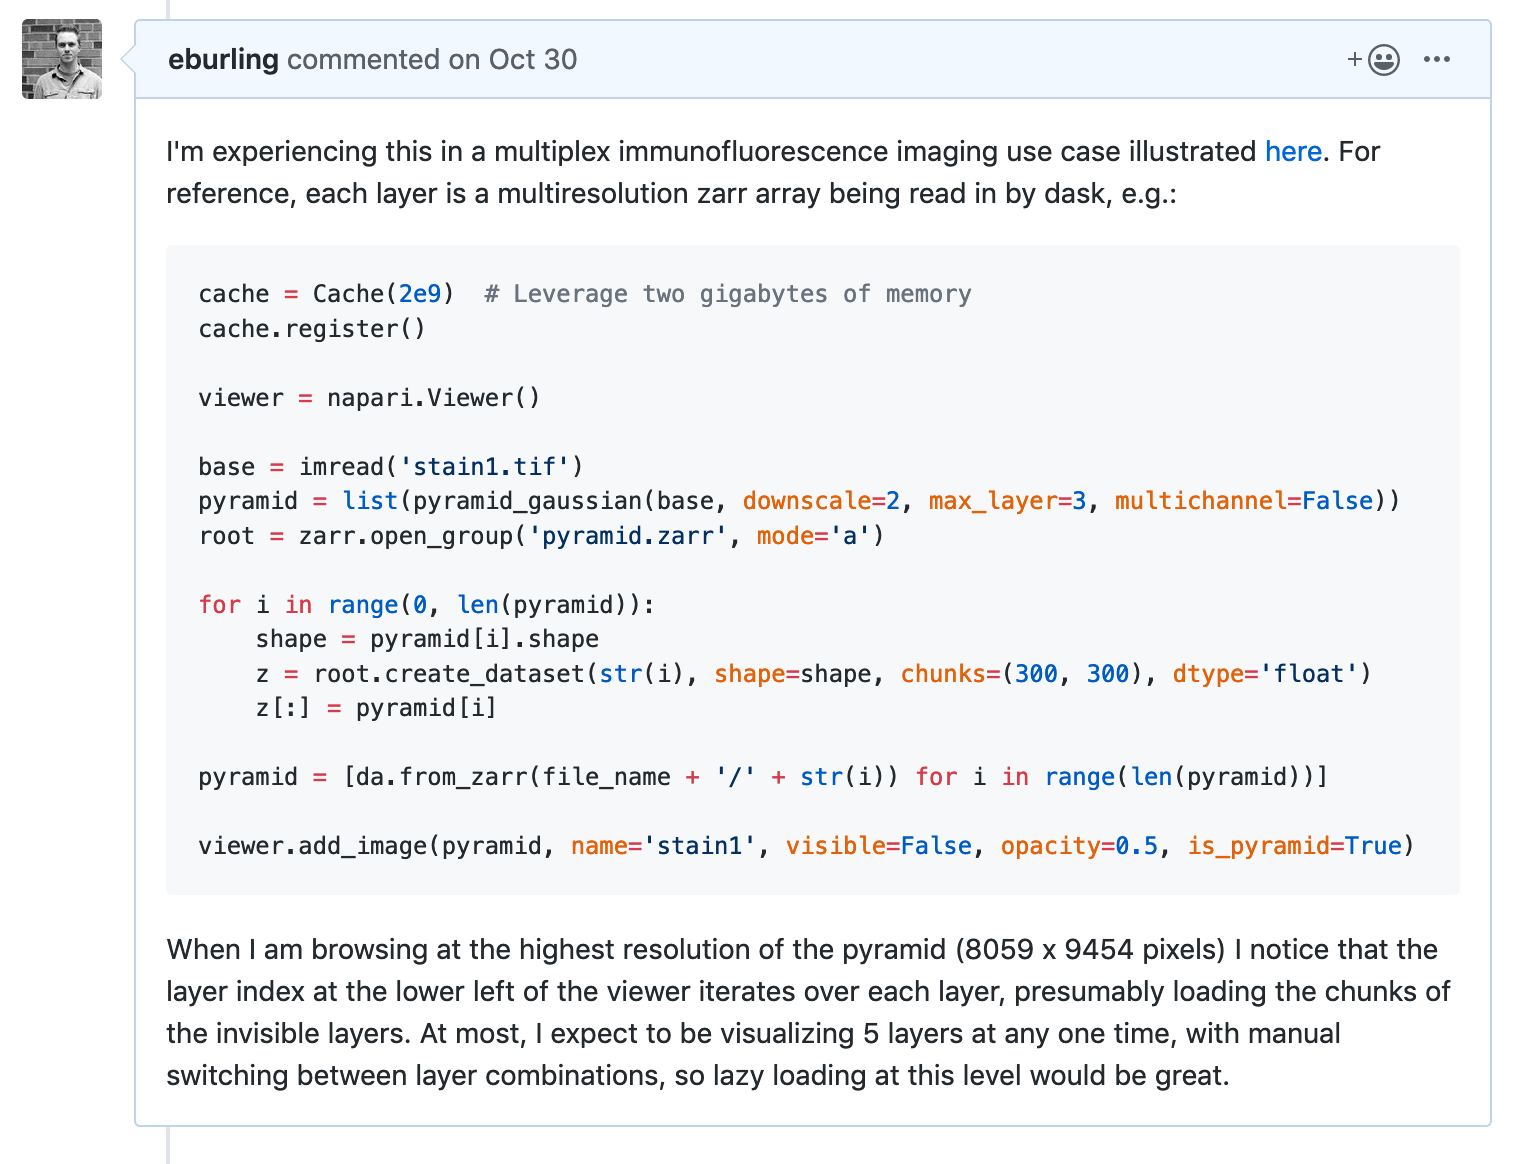

In [76]:
Image(filename = "/Users/burlinge/eburling.png", width=700, height=700)

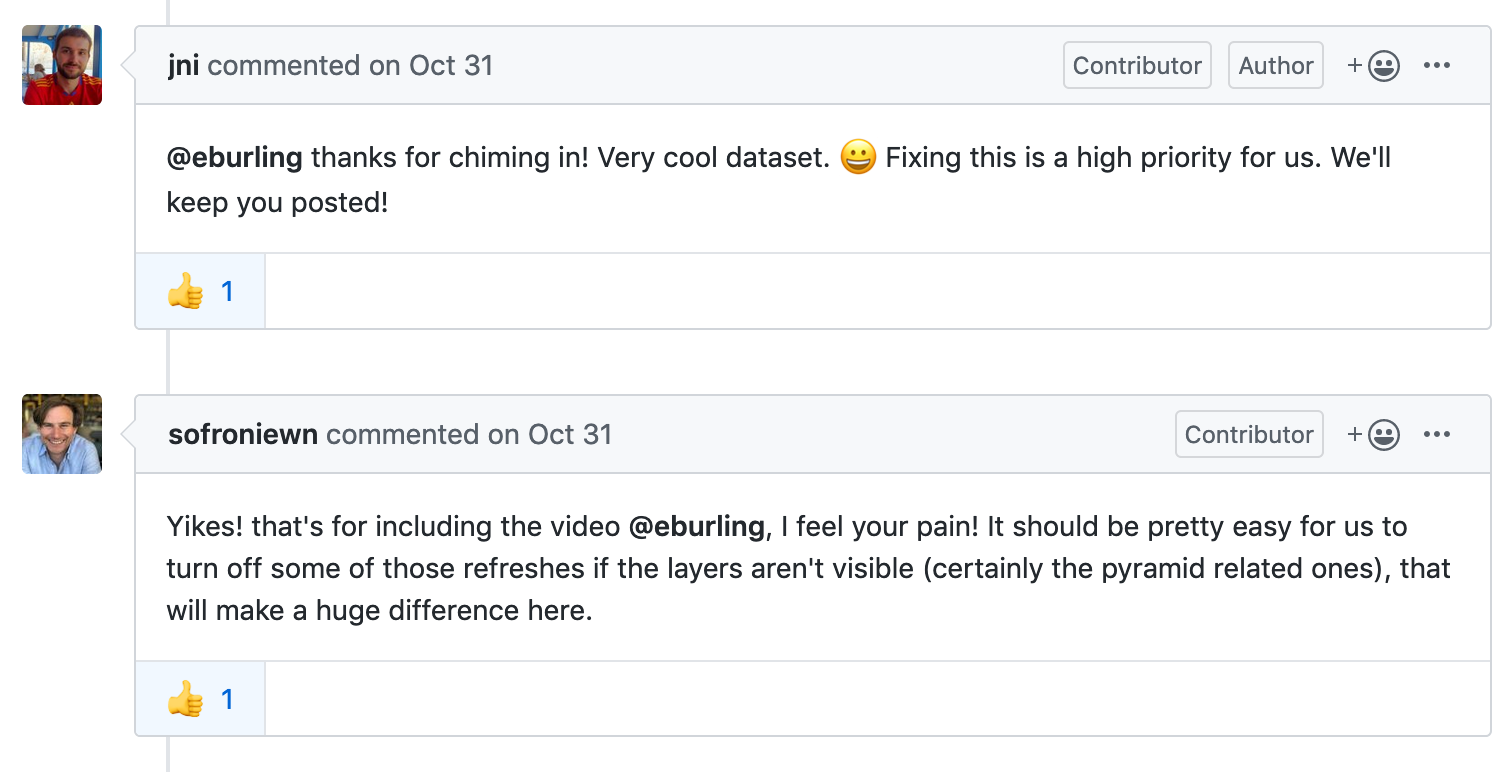

In [77]:
Image(filename = "/Users/burlinge/napari.png", width=700, height=700)

In [67]:
smt_viewer = napari.Viewer()
smt_root  = '/Users/burlinge/napari_demo/smt101'
zarr_root = '/Users/burlinge/napari_demo/smt101/zarrs-scene002-300'

d = {}
for fn in glob(f'{smt_root}/Registered*Scene-002*.tif'):
    bn  = os.path.basename(fn)
    tmp = bn.split('_')
    stains = ['DAPI'] + tmp[1].split('.')
    channel = int(tmp[3][-1])-1
    if channel == 0:
        stain = 'DAPI'
    else:
        stain = stains[channel]
    d[stain] = fn

In [68]:
for stain in tqdm.notebook.tqdm(sorted(d.keys(),reverse=True)):
    
    base = imread(d[stain])
    pyramid = list(pyramid_gaussian(base, downscale=2, max_layer=3, multichannel=False))
    
    file_name = f'{zarr_root}/{os.path.splitext(os.path.basename(d[stain]))[0]}.zarr'

    root = zarr.open_group(file_name, mode='a')
    
    for i in range(0, len(pyramid)):
        shape = pyramid[i].shape
        z = root.create_dataset(str(i), shape=shape, chunks=(300, 300), dtype='float')
        z[:] = pyramid[i]
    
    pyramid = [da.from_zarr(file_name + '/' + str(i)) for i in range(len(pyramid))]
    
    smt_viewer.add_image(pyramid,
                         name=stain,
                         blending='additive',
                         visible=False,
                         opacity=0.5,
                         is_pyramid=True)

In [61]:
for stain in tqdm.notebook.tqdm(sorted(d.keys(),reverse=True)):
    
    file_name = f'{zarr_root}/{os.path.splitext(os.path.basename(d[stain]))[0]}.zarr'
    pyramid = [da.from_zarr(file_name + '/' + str(i), chunks=(300,300)) for i in range(3)]
    smt_viewer.add_image(pyramid,
                         name=stain,
                         blending='additive',
                         visible=False,
                         opacity=0.5,
                         is_pyramid=True)

In [92]:
clust = pd.read_csv('/Users/burlinge/napari_demo/smt101/SMT101_SSC_N20.csv')

In [108]:
clust['patient']=clust.UNIQID.str.split('_').str.get(0).str.split('-').str.get(0)
clust['Bx']=clust.UNIQID.str.split('_').str.get(0).str.split('-').str.get(1)
clust['scene']=clust.UNIQID.str.split('_').str.get(1)

In [110]:
curr_clust = clust[(clust.Bx=='Bx1') & (clust.scene=='scene002')]

In [100]:
cell_labels = imread(glob(f'{smt_root}/Scene 002 - Cell Segmentation Basins.tif')[0])
cell_bounds = find_boundaries(cell_labels,mode='outer')

replace = {idx:cluster for idx,cluster in curr_clust['Label'].iteritems()}
mp = np.arange(0,cell_labels.max()-1)
mp[list(replace.keys())] = list((replace.values()))
data = mp[cell_labels]

smt_viewer.add_labels(data * ~cell_bounds, 
                       name='clusters',
                       blending='additive',
                       opacity=0.5)

IndexError: index 29727 is out of bounds for axis 0 with size 29727

In [107]:
cell_labels.max()

29727

In [112]:
curr_clust.head()

UNIQID   CD20_Ring    CD31_Ring   CD45_Ring  \
0  SMT101-Bx1_scene002_cell00136  155.909544   881.475054  675.826464   
1  SMT101-Bx1_scene002_cell00141  465.093261  1195.669565  697.988406   
2  SMT101-Bx1_scene002_cell00151  202.150000  1847.111111  678.244444   
3  SMT101-Bx1_scene002_cell00171  159.553738   868.093458  713.881620   
4  SMT101-Bx1_scene002_cell00183  152.819575   881.641509  713.591195   

      CD4_Ring     CD68_Ring     CD8_Ring    CK14_Ring   CK17_Ring  \
0   961.048445   1051.648590  1113.357918  1869.707158  177.502169   
1  2095.550725  26415.152174  8534.295652  4182.510870  540.278261   
2  1588.251852   8801.444444  3204.266667  2585.777778  343.400000   
3   976.911734   1166.308411  1293.376947  2057.632399  201.109034   
4  1006.937107   1149.858491  1295.094340  2091.356132  212.757075   

    CK19_Ring  ...  PCNA_Nuclei     PD1_Ring    PDPN_Ring     VIM_Ring  \
0  937.969631  ...   308.919139  1018.511931   550.314534   266.381779   
1  562.358261  ...   636.682353  1327.921739  2235.942029  3730.056522   
2  530.640000  ...   332.517241  1191.444444   761.425926  2746.541667   
3  926.928349  ...   327.292929  1251.115265   597.481828   195.060748   
4  987.518868  ...   320.711977  1433.141509   616.187107   199.931604   

     aSMA_Ring  pHH3_Nuclei  Label  patient   Bx     scene  
0   197.610629   189.988131      6   SMT101  Bx1  scene002  
1  1019.867391   639.900000     18   SMT101  Bx1  scene002  
2   819.983333   214.875000     14   SMT101  Bx1  scene002  
3   174.085670   208.821970      3   SMT101  Bx1  scene002  
4   181.429245   200.769011      3   SMT101  Bx1  scene002  

[5 rows x 27 columns]

### Miltenyi data
* The new Miltenyi MACSima system is coming online January 2020.

In [121]:
miltenyi_root = '/Users/burlinge/napari_demo/miltenyi/R-0_W-B-3_G-2_F-4'
all_fns  = natsorted(glob(f'{miltenyi_root}/0*')) # exclude bleach images
dapi_fns = [os.path.basename(fn) for fn in all_fns if 'DAPI' in fn]

In [122]:
bns = [os.path.basename(fn) for fn in all_fns if 'DAPI' not in fn]
groups = [list(g) for _, g in itertools.groupby(bns, lambda x: x.rsplit('_',2)[0])]

In [123]:
miltenyi_viewer = napari.Viewer()

selected_fns = dapi_fns + [g[2] for g in groups] # get max exposure images

for fn in tqdm.notebook.tqdm(selected_fns):
    fn_split = fn.split('_')
    if fn_split[0] == '000':
        if 'DAPI' in fn:
            stain = fn_split[1].split('.')[0]
        else:    
            stain = fn_split[1]
    else:
        stain = fn_split[1].split('REA')[0]
        
    miltenyi_viewer.add_image(imread(os.path.join(miltenyi_root,fn)),
                              name=stain,
                              blending='additive',
                              visible=False,
                              opacity=0.5)

scene = 'R-0_W-B-3_G-2_F-4'
c_lab = imread(f'/Users/burlinge/napari_demo/miltenyi/Segmentation/OSHU_Res/{scene}/{scene}/export/CellLabels.tif')
miltenyi_viewer.add_labels(c_lab,name='Miltenyi cells',blending='additive',visible=False,opacity=0.5)

n_lab = imread(f'/Users/burlinge/napari_demo/miltenyi/Segmentation/OSHU_Res/{scene}/{scene}/export/NucleiLabels.tif')
miltenyi_viewer.add_labels(n_lab,name='Miltenyi nucs',blending='additive',visible=False,opacity=0.5)

g_c_lab = imread('/Users/burlinge/napari_demo/miltenyi/Guillaume_Segmentation/Scene 04_ - Cell Segmentation Basins.tif')
miltenyi_viewer.add_labels(g_c_lab,name='Guillaume cells',blending='additive',visible=False,opacity=0.5)

g_n_lab = imread('/Users/burlinge/napari_demo/miltenyi/Guillaume_Segmentation/Scene 04_ - Nuclei Segmentation Basins.tif')
miltenyi_viewer.add_labels(g_n_lab,name='Guillaume nucs',blending='additive',visible=False,opacity=0.5)

<Labels layer 'Guillaume nucs' at 0x251f716a0>